# CMPE462 Project 1
## Çağatay Doruk Balcı - Uras Varolgüneş
## 2015300000 -2015300210

In [138]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [139]:
#Import Dataset, groupby Club and Season to create regression dataset
player = pd.read_excel("train_data.xlsx",sheetname="Player")
point = pd.read_excel("train_data.xlsx",sheetname = "Points")
age_value = player.groupby(["Club","Season"]).mean()[["Market Value","Age"]]

In [140]:
point = point.set_index(['Club', 'Season']).sort_index()

# Feature Engineering & Exploratory Data Analysis

In [141]:
#assign the relevant features to merged dataframe
merged=pd.DataFrame()
"""Better players lead to more success, teams' market values indicate their players' values."""
merged["Market Value"] = player.groupby(["Club","Season"]).mean()["Market Value"]
"""Footballers have prime ages, which they are most athletic and peak at their games, therefore ages of players'
might affect teams' success"""
merged["Age"] = player.groupby(["Club","Season"]).mean()["Age"]
merged["Points"] = point["Points"]
"""Since Turkey is a smaller market compared to world and excess demand for Turkish players is higher,teams buy foreign
players because usually they get better players for the same price they would pay for a Turkish player."""
merged["Foreign"]=player.groupby(["Club","Season"]).sum()["Foreign"]
"""Unsuccesful teams might transfer more players to get better, thus expanding their squad size.Total Players and 
Foreign ratio might demonstrate this effect."""
merged["Total"] = player.groupby(["Club","Season"]).count()['Foreign']
merged["Foreign_Ratio"] = merged["Foreign"] / merged["Total"]
"""Multinational players are considered a proxy for foreign players."""
merged["Multinational"] = player.groupby(["Club","Season"]).sum()["Multinational"]
"""How much a teams' value changed might indicate teams' past success and expensive transfers that are expected to 
boost team's success."""
merged["Value_chg"] = merged["Market Value"].pct_change()

In [142]:
#Check for missing data
merged.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 162 entries, (Akhisarspor, 2012) to (Trabzonspor, 2015)
Data columns (total 8 columns):
Market Value     162 non-null float64
Age              162 non-null float64
Points           161 non-null float64
Foreign          162 non-null int64
Total            162 non-null int64
Foreign_Ratio    162 non-null float64
Multinational    162 non-null int64
Value_chg        161 non-null float64
dtypes: float64(5), int64(3)
memory usage: 10.9+ KB


In [143]:
#drop missing data
merged.dropna(inplace=True)

#### As seen below, the relationship between Market Value and Points seems to be non-linear. Thus we take the logarithm of Market Value to observe the relation better.

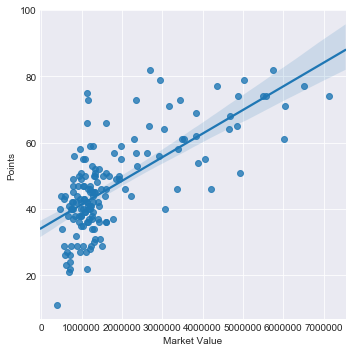

In [94]:
sns.set_style("darkgrid")
sns.lmplot(x="Market Value",y="Points",data=merged)

Market Value-Points Correlation
 [[ 1.          0.70036489]
 [ 0.70036489  1.        ]]
Log Market Value-Points Correlation
 [[ 1.          0.72358174]
 [ 0.72358174  1.        ]]


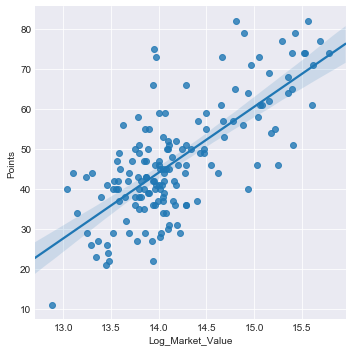

In [144]:
merged["Log_Market_Value"] = np.log(merged["Market Value"])
print("Market Value-Points Correlation\n",np.corrcoef(merged["Market Value"],merged["Points"]))
print("Log Market Value-Points Correlation\n",np.corrcoef(merged["Log_Market_Value"],merged["Points"]))
sns.lmplot(x="Log_Market_Value",y="Points",data=merged) 

#### Percent change of market value and points doesn't seem to have a significant relationship.

Value Change(Pct) - Points Correlation 
 [[ 1.          0.28544839]
 [ 0.28544839  1.        ]]


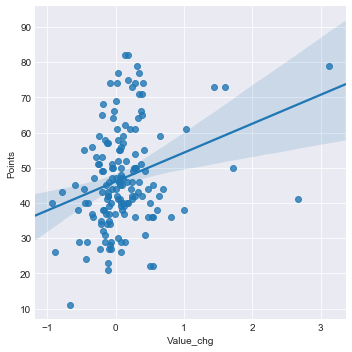

In [12]:
print("Value Change(Pct) - Points Correlation \n",np.corrcoef(merged["Value_chg"],merged["Points"]))
sns.lmplot(x="Value_chg",y="Points",data=merged)

#### For some teams same success every year is expected. Teams may not diverge too much from their average. That's why we look at the relationship between average points and points.

In [145]:
point = pd.read_excel("train_data.xlsx",sheetname = "Points")
Average_Points= point.groupby("Club").mean()["Points"]
point['Average'] = point.Club.apply(lambda x: Average_Points[x])
point=point.set_index(["Club","Season"]).sort_index()
merged["Average"] = point["Average"]

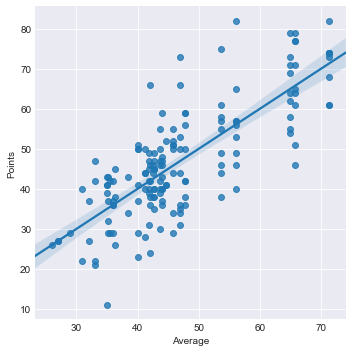

In [15]:
sns.lmplot(x="Average",y="Points",data=merged)

### It seem we were right about our intuition on total players, teams with bigger squads tend to be less succesful.

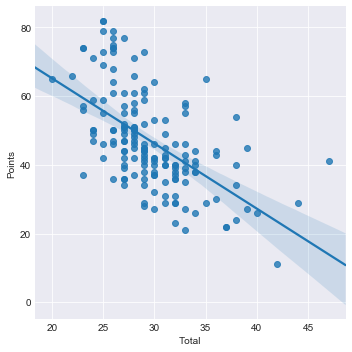

In [40]:
sns.lmplot(x="Total",y="Points",data=merged)

### We take a look at the remaining variables' relationship with points.

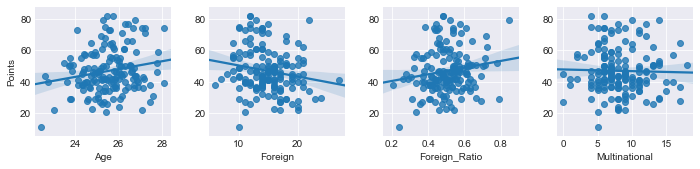

In [53]:
sns.pairplot(merged,y_vars="Points",x_vars = merged.drop(["Points","Log_Market_Value","Market Value",
                                                          "Value_chg","Total","Average"],axis=1).columns,kind="reg")

#### Age and  Foreign Ratio demonstrate a positive correlation with points while amount of foreign players seems to have a negative relationship. Relationship between multinational and points doesn't seem significant.

### Do Brazilian players actually have a siginificant effect on teams' successes?

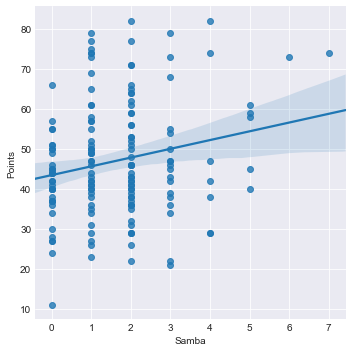

In [146]:
player["Samba"]=pd.get_dummies(player["Nationality"])["Brazil"]
merged["Samba"] = player.groupby(["Club","Season"])["Samba"].sum()
sns.lmplot(x="Samba",y="Points",data=merged)

In [150]:
merged.drop("Samba",axis=1,inplace=True)

# Models

In [71]:
from sklearn.linear_model import LinearRegression

In [72]:
from sklearn.model_selection import train_test_split

## First Model with all variables

In [97]:
merged.head()

Market Value        Age  Points  Foreign  Total  \
Club        Season                                                    
Akhisarspor 2013    4.870370e+05  26.777778    44.0       10     27   
            2014    9.757812e+05  27.468750    38.0       16     32   
            2015    1.206897e+06  27.793103    46.0       16     29   
Ankaragücü  2007    9.701613e+05  25.258065    43.0       13     31   
            2008    1.090909e+06  25.666667    39.0       11     33   

                    Foreign_Ratio  Multinational  Value_chg  Log_Market_Value  \
Club        Season                                                              
Akhisarspor 2013         0.370370              7   0.003338         13.096095   
            2014         0.500000             11   1.003505         13.790994   
            2015         0.551724             12   0.236852         14.003563   
Ankaragücü  2007         0.419355              7  -0.196152         13.785218   
            2008         0.333333              8   0.124462         13.902522   

                    Average  
Club        Season           
Akhisarspor 2013       42.5  
            2014       42.5  
            2015       42.5  
Ankaragücü  2007       35.0  
            2008       35.0

In [98]:
X = merged.drop(["Points","Log_Market_Value","Average"],axis=1)
y = merged["Points"]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [100]:
reg1 = LinearRegression()

In [101]:
reg1.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Age, Foreign, Total and Value Change are in line with our expectation. Market Value's coefficient value is less than our expectations and Foreign Ratio's coefficient is unexpectedly negative. 

In [102]:
coef = pd.DataFrame(index=X.columns)
coef["coefficients"]=reg1.coef_ 
coef

,coefficients
Market Value,0.000006
Age,0.223757
Foreign,2.851861
Total,-2.611356
Foreign_Ratio,-95.859966
Multinational,0.209209
Value_chg,2.875687


In [103]:
predictions = reg1.predict(X_test)

In [104]:
from sklearn import metrics
print("MSE: ", metrics.mean_squared_error(y_test,predictions))
print("R^2: ",metrics.r2_score(y_test,predictions))

MSE:  80.006108909
R^2:  0.695210287642


## Second Model without variables found to be irrelevant in Exploratory Data Analysis

#### We drop Multinational, Value Change(Percent).Add Average and switch Market Value with Log Market Value

#### We also drop age, because the relationship between age and points is not clear, especially in Turkey, where old stars frequently come to.

In [105]:
"""Multinational and Value change(pct) were found to be irrelevant and we replaced Market Value with Log Market Val"""
X = merged.drop(["Points","Multinational","Market Value","Value_chg","Age"],axis=1)
y = merged["Points"]

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [107]:
reg2 = LinearRegression()

In [108]:
reg2.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [109]:
coef = pd.DataFrame(index=X.columns)
coef["coefficients"]=reg2.coef_ 
coef

,coefficients
Foreign,1.791733
Total,-1.858397
Foreign_Ratio,-56.292080
Log_Market_Value,2.283073
Average,0.715233


In [110]:
predictions = reg2.predict(X_test)
print("MSE: ", metrics.mean_squared_error(y_test,predictions))
print("R^2: ",metrics.r2_score(y_test,predictions))

MSE:  61.9492459412
R^2:  0.763999360691


### There are many players in a team's squad which don't affect teams' success such as young prospects, unsuccesful players that can't be transfered however need to paid etc. Therefore we thought a variable which indicates the mean value of the best players might be a good indicator of a teams' success.   

### We wrote a loop to find the optimal number of players which explain variance the most.

In [152]:
for i in range(6,20):
    Exp_Players=player.groupby(["Club","Season"]).apply(lambda x: x.nlargest(i,'Market Value').mean())
    merged['L_Exp']= np.log(Exp_Players["Market Value"])
    X = merged.drop(["Points","Multinational","Market Value","Value_chg","Age"],axis=1)
    y = merged["Points"]
    X_train, X_test, y_train , y_test = train_test_split(X,y,test_size=0.2, random_state=10)
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    predictions = reg.predict(X_test)
    print(i,"most expensive player")
    print("MSE: ", metrics.mean_squared_error(y_test,predictions))
    print("R^2: ",metrics.r2_score(y_test,predictions))

6 most expensive player
MSE:  60.9660561274
R^2:  0.767744901433
7 most expensive player
MSE:  60.0146661392
R^2:  0.77136929818
8 most expensive player
MSE:  58.7783101835
R^2:  0.776079295719
9 most expensive player
MSE:  57.6113903458
R^2:  0.780524770777
10 most expensive player
MSE:  56.4937671146
R^2:  0.784782446445
11 most expensive player
MSE:  55.4858015983
R^2:  0.78862237222
12 most expensive player
MSE:  53.8691456841
R^2:  0.794781153066
13 most expensive player
MSE:  53.2528228431
R^2:  0.797129084542
14 most expensive player
MSE:  52.8418179054
R^2:  0.798694840938
15 most expensive player
MSE:  52.6798325566
R^2:  0.799311937164
16 most expensive player
MSE:  52.4367777473
R^2:  0.800237874026
17 most expensive player
MSE:  52.5330508381
R^2:  0.799871113937
18 most expensive player
MSE:  52.7233705965
R^2:  0.799146075497
19 most expensive player
MSE:  53.2580454152
R^2:  0.797109188733


### As seen above 16 players explain the variance of our dependent variable the most, with R^2:  0.799146075497. Also, below we looked at points' relation with Exp and Log Exp, Log Exp is more correlated with Points therefore we decided on Log Exp to be on the final model.

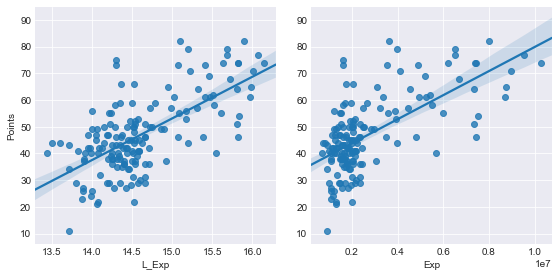

In [153]:
Exp_Players=player.groupby(["Club","Season"]).apply(lambda x: x.nlargest(16,'Market Value').mean())
log_exp = np.log(Exp_Players["Market Value"])
merged["L_Exp"] = log_exp
merged["Exp"] = Exp_Players["Market Value"]
sns.pairplot(merged,x_vars=["L_Exp","Exp"],y_vars="Points",kind="reg",size=4)

## Final Model

### Final variables that will be included in the model are:
    Foreign, Foreign_Ratio, Total, Average, Log Mean Market Value, Log Expensive Players(18) Mean Market Value

In [154]:
merged.head()

Market Value        Age  Points  Foreign  Total  \
Club        Season                                                    
Akhisarspor 2013    4.870370e+05  26.777778    44.0       10     27   
            2014    9.757812e+05  27.468750    38.0       16     32   
            2015    1.206897e+06  27.793103    46.0       16     29   
Ankaragücü  2007    9.701613e+05  25.258065    43.0       13     31   
            2008    1.090909e+06  25.666667    39.0       11     33   

                    Foreign_Ratio  Multinational  Value_chg  Log_Market_Value  \
Club        Season                                                              
Akhisarspor 2013         0.370370              7   0.003338         13.096095   
            2014         0.500000             11   1.003505         13.790994   
            2015         0.551724             12   0.236852         14.003563   
Ankaragücü  2007         0.419355              7  -0.196152         13.785218   
            2008         0.333333              8   0.124462         13.902522   

                    Average      L_Exp        Exp  
Club        Season                                 
Akhisarspor 2013       42.5  13.498228   728125.0  
            2014       42.5  14.249725  1543750.0  
            2015       42.5  14.366158  1734375.0  
Ankaragücü  2007       35.0  14.297165  1618750.0  
            2008       35.0  14.342456  1693750.0

In [155]:
#final merged df with relevant variables
merged.drop(["Market Value","Age","Multinational","Value_chg","Exp"],axis=1,inplace=True)

In [156]:
X = merged.drop("Points",axis=1)
y= merged["Points"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
final_model = LinearRegression()
final_model.fit(X_train,y_train)
coef = pd.DataFrame(index=X.columns)
coef["coefficients"]=final_model.coef_ 
coef

,coefficients
Foreign,1.429522
Total,-1.061686
Foreign_Ratio,-46.500153
Log_Market_Value,33.241947
Average,0.718713
L_Exp,-30.981949


In [157]:
predictions = final_model.predict(X_test)
print("MSE: ", metrics.mean_squared_error(y_test,predictions))
print("R^2: ",metrics.r2_score(y_test,predictions))

MSE:  52.4367777473
R^2:  0.800237874026
